In [18]:
# autoreload
%reload_ext autoreload
%autoreload 2

## Cleaning coordinates
Create a new column in the df with the 'gold standard' coordinates. These are coordinates in decimal degree format. Save as a csv for export to GEE. Sense-check each point, refine, and transfer final files (as csv and yaml) to Ben H. 

Where coordinates are explicitly available in papers, use these. Where not available, take 'location' and search for coordinates using Google Maps API. 

In [64]:
### imports
# general
import pandas as pd
import re
import googlemaps

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# custom
from calcification import utils, config

In [102]:
### load data
fp = config.data_dir / "Orlando_data.xlsx"
df = utils.process_df(pd.read_excel(fp, sheet_name="all_data"))

# create column and fill with cleaned coordinates, where 
df['loc'] = df['cleaned_coords'].fillna(df['location'])
# df['loc'].value_counts()

Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.

Duplicate DOIs found, treat with caution:
['10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0', '10.1007/s00227-012-2001-y']


In [104]:
### get locations for which there are no coordinates (from location, where cleaned_coords is NaN)
locs = df.loc[df['cleaned_coords'].isna(), 'location'].unique()
# get coordinates for these locations using Google Maps API
gmaps_coords = {}
GMAPS_API_KEY = utils.read_yaml(config.resources_dir / "api_keys.yaml")['google_maps_api']
gmaps_client = googlemaps.Client(key=GMAPS_API_KEY)

for loc in locs:
    gmaps_coords[loc] = tuple(utils.get_coordinates_from_gmaps(loc, gmaps_client).values)   # slightly hacky formatting since originally written for processing dataframe column
gmaps_coords

{'Palmyra Atoll': (np.float64(5.8885026), np.float64(-162.0786656)),
 'Fiji, UK aquarium': (np.float64(55.378051), np.float64(-3.435973)),
 'Aquarium': (None, None),
 'Island Point, Panama': (np.float64(8.537981), np.float64(-80.782127)),
 "Mo'orea, French Polynesia": (np.float64(-17.5388435),
  np.float64(-149.8295234)),
 'Gulf of Aqaba, Jordan': (np.float64(28.6929261), np.float64(34.7298765)),
 'Okinawa, Japan': (np.float64(26.3343533), np.float64(127.8056058)),
 'Hawaii, various': (np.float64(19.8986819), np.float64(-155.6658568)),
 'Oku Reef, Okinawa, Japan': (np.float64(26.8271449), np.float64(128.2796738)),
 'Indo-Pacific': (None, None),
 'Biscayne National Park, Florida Keys': (np.float64(25.5722),
  np.float64(-80.2321)),
 'Key West, Florida Keys': (np.float64(24.5550593), np.float64(-81.7799871)),
 'Key Biscayne, Florida Keys': (np.float64(25.693713),
  np.float64(-80.1628248)),
 'Florida Bay, Florida Keys': (np.float64(24.9586323),
  np.float64(-80.67985209999999)),
 'Florid

In [69]:
unique_coords = df['cleaned_coords'].unique()

failed_coords = []
for coord in unique_coords:
    standardised_coord = utils.standardize_coordinates(coord)
    if not standardised_coord:
        failed_coords.append(coord)
    else:
        print('OG:', coord, 'Standardised:', standardised_coord)

OG: 14°41′17.4′′S, 145°28′03.6′′E / 14°41′47.0′′S, 145°27′02.9′′E Standardised: (np.float64(-14.692277777777779), np.float64(145.45923611111112))
OG: 17°28′40.51′′S, 149°50′22.80′′W Standardised: (-17.477919444444442, 149.8396666666667)
OG: 25.02° N, 80.49° W Standardised: (25.02, 80.49)
OG: 26°19.62’N, 80°04.33’W Standardised: (26.327, 80.07216666666666)
OG: nan Standardised: nan
OG: 17.05°N 111.30°E Standardised: (17.05, 111.3)
OG: 23°26′S 151°52′E Standardised: (-23.433333333333334, 151.86666666666667)
OG: 18°12′N, 109°28′E Standardised: (18.2, 109.46666666666667)
OG: 9.3326, -82.2164 Standardised: (9.3326, -82.2164)
OG: 9.22025, -82.3231 Standardised: (9.22025, -82.3231)
OG: 23 33’S, 151 54’E Standardised: (-23.55, 151.9)
OG: 18° 41.126′S, 146° 30.731′E Standardised: (-18.685433333333332, 146.51218333333333)
OG: 24.62055° N, 81.37078° W Standardised: (24.62055, 81.37078)
OG: 21.955°N, 120.766°E / 21.931°N, 120.745°E Standardised: (np.float64(21.942999999999998), np.float64(120.7555

In [107]:
df['loc'].nunique()

130

In [83]:
df['loc']

0       (-14.692277777777779, 145.45923611111112)
1       (-14.692277777777779, 145.45923611111112)
2       (-14.692277777777779, 145.45923611111112)
3       (-14.692277777777779, 145.45923611111112)
4       (-14.692277777777779, 145.45923611111112)
                          ...                    
6999                                         None
7000                                         None
7001                                         None
7042                                         None
7043                                         None
Name: loc, Length: 4041, dtype: object

In [119]:
# fill loc with standardised cleaned_coords if not NaN, otherwise fill with coordinates extracted from location
# df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None).fillna(df['location'].map(gmaps_coords))
df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None)
# For locations where coordinates from cleaned_coords are available, fill them in
# # For remaining locations, use the coordinates from Google Maps API if available
df['loc'] = df['loc'].fillna(df['location'].map(gmaps_coords))

# # Extract latitude and longitude from the coordinate tuples, with proper type checking
df['latitude'] = df['loc'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
df['longitude'] = df['loc'].apply(lambda x: x[1] if isinstance(x, tuple) else None)

In [121]:
locs_df

,location,latitude,longitude
10.1111/jpy.13290,"Lizard Island, GBR, Australia",-14.692278,145.459236
10.1038/s41598-019-40620-8-LOC-A,"Mo'orea, French Polynesia",-17.477919,149.839667
10.1038/s41598-019-40620-8-LOC-B,"Key Largo, Florida, US",25.020000,80.490000
10.3354/meps11591,"Boca Raton, Florida, US",26.327000,80.072167
10.3354/meps09309,Palmyra Atoll,5.888503,-162.078666
...,...,...,...
10.1098/rspb.2015.1887,"Puerto Morelos, Mexico",20.847808,-86.875534
10.1016/j.ecss.2009.03.038,"Chwaka Bay, Zanzibar",-6.143635,39.465738
10.3354/meps11655,"Broad Key, Florida, US",25.351226,-80.265052
10.1038/srep19030,"reef lagoon, Puerto Morelos, Mexico, Caribbean",20.847808,-86.875534


In [125]:
### save to yaml, using (uniquified) doi as key, latitude, longitude as values
temp_df = df.copy()
temp_df['location_lower'] = temp_df['location'].str.lower()

# Set index and drop duplicates based on the lowercase columns
locs_df = temp_df.set_index('doi').drop_duplicates(['location_lower', 'cleaned_coords', 'latitude', 'longitude'])[['location', 'latitude', 'longitude']]


# locs_df = df.set_index('doi').drop_duplicates(['location', 'cleaned_coords', 'latitude', 'longitude'])[['location', 'latitude', 'longitude']]
locs_df.dropna(subset=['latitude', 'longitude'], inplace=True) # remove empty rows
dois = locs_df.index
# make any duplicated index values unique by appending a letter
locs_df.index = utils.uniquify_repeated_values(dois)
# send to dictionary
locs_dict = locs_df.to_dict(orient='index')
# save dictionary to yaml
utils.write_yaml(locs_dict, config.resources_dir / "locations.yaml")
print(f'Saved locations to {config.resources_dir / "locations.yaml"}')
locs_df.to_csv(config.resources_dir / "locations.csv", index=True, index_label='doi')
print(f'Saved locations to {config.resources_dir / "locations.csv"}')
locs_df

Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.yaml
Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.csv


,location,latitude,longitude
10.1111/jpy.13290,"Lizard Island, GBR, Australia",-14.692278,145.459236
10.1038/s41598-019-40620-8-LOC-A,"Mo'orea, French Polynesia",-17.477919,149.839667
10.1038/s41598-019-40620-8-LOC-B,"Key Largo, Florida, US",25.020000,80.490000
10.3354/meps11591,"Boca Raton, Florida, US",26.327000,80.072167
10.3354/meps09309,Palmyra Atoll,5.888503,-162.078666
...,...,...,...
10.1098/rspb.2015.1887,"Puerto Morelos, Mexico",20.847808,-86.875534
10.1016/j.ecss.2009.03.038,"Chwaka Bay, Zanzibar",-6.143635,39.465738
10.3354/meps11655,"Broad Key, Florida, US",25.351226,-80.265052
10.1038/srep19030,"reef lagoon, Puerto Morelos, Mexico, Caribbean",20.847808,-86.875534


## Visualising

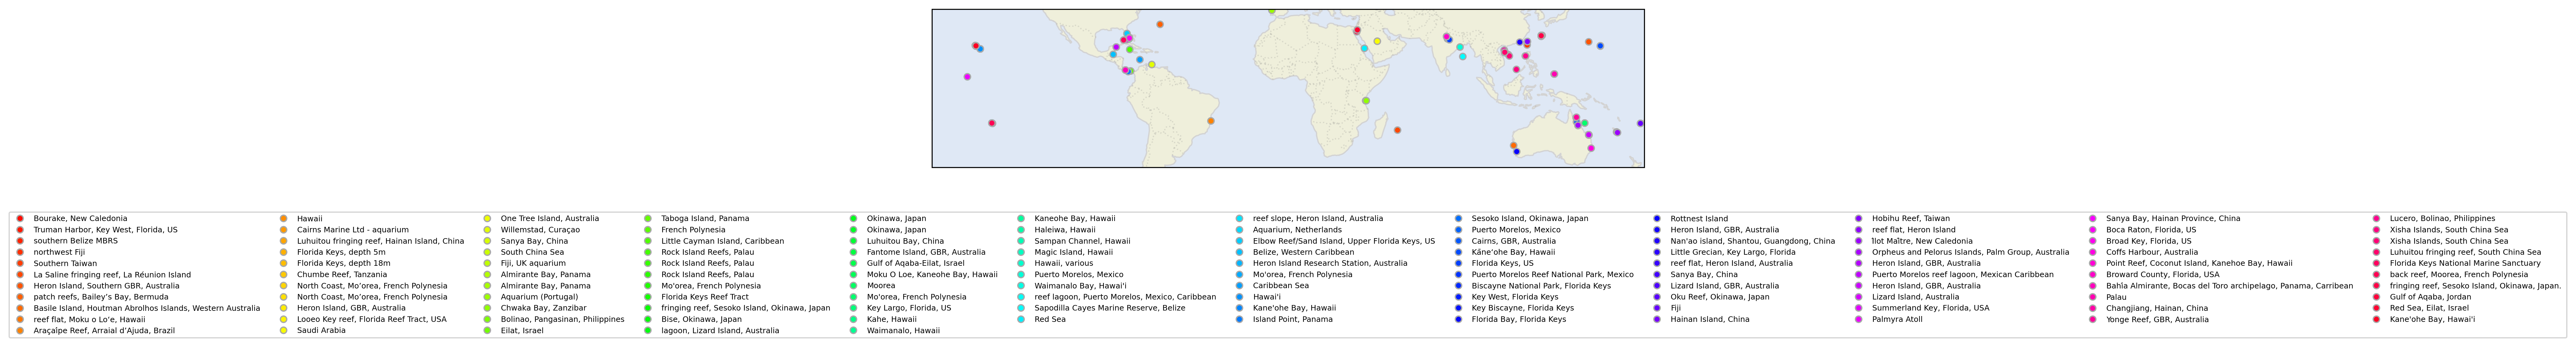

In [126]:
### plot spatial disribution of studies

locs = utils.read_yaml(config.resources_dir / "locations.yaml")   # read locations.yaml
locs_df = pd.DataFrame(locs).T
locs_df = locs_df.dropna()  # drop nans

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

# add locations with colors
colors = sns.color_palette("hsv", len(locs_df))
for i, (doi, row) in enumerate(locs_df.iterrows()):
    data = locs[doi]
    ax.plot(data["longitude"], data["latitude"], 'o', markeredgecolor='darkgrey', markersize=5, color=colors[i], transform=ccrs.PlateCarree(), label=data["location"])

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1), ncol=len(locs_df)//10, fontsize=6);   # add legend